# **差分进化算法在组合优化中的应用**

## <font color = 'midnightblue'> **数据选取** </font>

在用实际数据测试阶段，主要是选取股票风格指数和大类资产例如债券和大宗商品，并构建三个投资组合分开进行配置策略研究。在第一个组合中，我们首先选用了市场上从2010/06/01至2020/09/30的11个ETF时间序列数据，分别为：*金融地产，上中游，下游，消费，成长，大盘成长，大盘价值，中盘成长，中盘价值，小盘成长，小盘价值*。 在第二个投资组合中，选取前文的股票风格ETF和剩余的大类资产指数：*中证全债，有色金属，易盛能化A，黄金*。在第三个组合中，只选取大类资产指数：*债券、有色金属、能源化工和黄金合约*，并将资金在其中分配寻找最优解。

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import DE as de
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']

#### **首先导入组合 1 的时间序列数据**

In [2]:
col_names1 = ['万得全A','金融地产','上中游','下游','消费','成长','大盘成长','大盘价值','中盘成长','中盘价值','小盘成长','小盘价值']
prices_p1 = pd.read_csv(U"C:/Users/YUAN PUEN/Desktop/金融工程/JupyterLab/Data/stocks.csv",names = col_names1,header = 0,index_col=0,parse_dates=True)
prices_p1.columns = prices_p1.columns.str.strip()
prices_p1 = prices_p1.dropna()
prices_p1 = prices_p1.iloc[:,1:]
prices_p1.head(2)

,金融地产,上中游,下游,消费,成长,大盘成长,大盘价值,中盘成长,中盘价值,小盘成长,小盘价值
2010-05-31,3699,2714,4670,5425,1000.0,2826,3628,3467,3680,3790,4175
2010-06-01,3661,2703,4600,5353,973.0,2792,3590,3407,3602,3715,4088


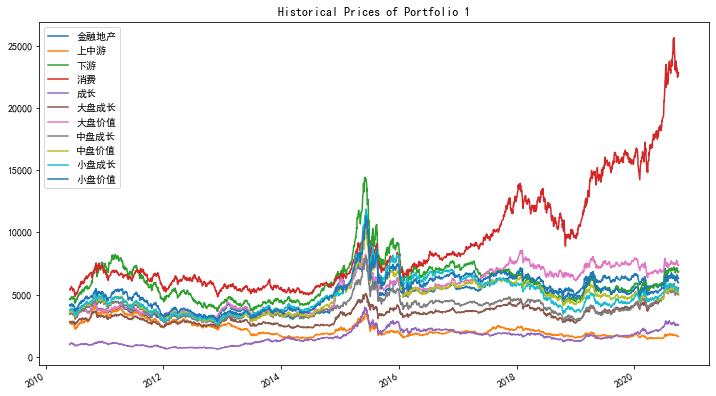

In [3]:
#显示资产组合一的历史数据
prices_p1.plot(figsize=(12,7),title = "Historical Prices of Portfolio 1")

In [4]:
#由过去资产组合一的价格数据计算各类指数的收益
rets_p1 = prices_p1.pct_change().dropna()
rets_p1.head(2)

,金融地产,上中游,下游,消费,成长,大盘成长,大盘价值,中盘成长,中盘价值,小盘成长,小盘价值
2010-06-01,-0.010273,-0.004053,-0.014989,-0.013272,-0.027000,-0.012031,-0.010474,-0.017306,-0.021196,-0.019789,-0.020838
2010-06-02,0.001912,0.001480,0.014783,0.003363,0.024666,0.007880,-0.001950,0.011741,0.014436,0.012651,0.011742


In [5]:
#计算协方差矩阵
covmax_p1 = rets_p1.cov()
covmax_p1.head(2)

,金融地产,上中游,下游,消费,成长,大盘成长,大盘价值,中盘成长,中盘价值,小盘成长,小盘价值
金融地产,0.000252,0.000201,0.000190,0.000158,0.000158,0.000214,0.000219,0.000179,0.000200,0.000174,0.000190
上中游,0.000201,0.000313,0.000258,0.000195,0.000225,0.000215,0.000185,0.000237,0.000257,0.000242,0.000257


In [6]:
#计算相关性矩阵
corr_p1 = rets_p1.corr()
corr_p1.head(2)

,金融地产,上中游,下游,消费,成长,大盘成长,大盘价值,中盘成长,中盘价值,小盘成长,小盘价值
金融地产,1.000000,0.715307,0.680719,0.625879,0.500125,0.892246,0.966902,0.683524,0.768563,0.635914,0.704744
上中游,0.715307,1.000000,0.828778,0.690121,0.640757,0.802643,0.731379,0.811653,0.886448,0.793270,0.853789


##### 可以发现由于资产组合一中仅包含单一的股票类资产，因而相关性较高。

---

#### **导入资产组合 2 的时间序列数据**

In [8]:
col_names2 = ['万得全A','金融地产','上中游','下游','消费','成长','大盘成长','大盘价值','中盘成长','中盘价值','小盘成长','小盘价值','中证全债','有色金属','易盛能化A','黄金']
prices_p2 = pd.read_csv(U"C:/Users/YUAN PUEN/Desktop/金融工程/JupyterLab/Data/indices.csv",names = col_names2, header = 0,index_col=0,parse_dates=True)
prices_p2.columns = prices_p2.columns.str.strip()
prices_p2 = prices_p2.dropna()
prices_p2 = prices_p2.iloc[:,1:]
prices_p2.head(2)

,金融地产,上中游,下游,消费,成长,大盘成长,大盘价值,中盘成长,中盘价值,小盘成长,小盘价值,中证全债,有色金属,易盛能化A,黄金
2012-01-04,3037,2355,4549,5436,707.0,2401,3258,2838,2974,2921,3265,139.55,3144.17,958.22,328.72
2012-01-05,3049,2311,4415,5293,667.0,2387,3276,2737,2899,2808,3162,139.50,3159.13,973.84,331.98


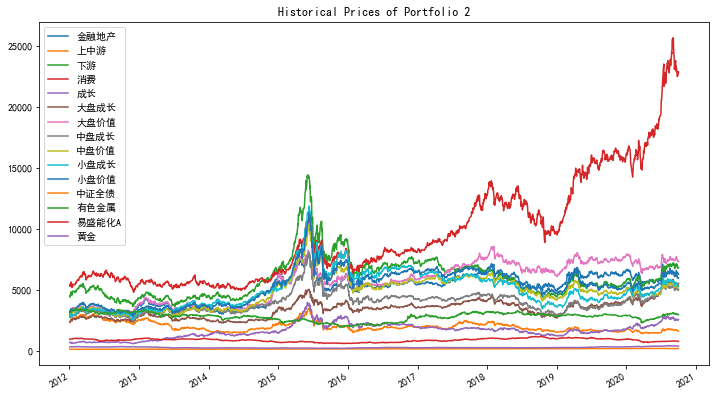

In [9]:
prices_p2.plot(figsize=(12,7),title = "Historical Prices of Portfolio 2")

In [10]:
#根据资产组合的价格计算资产的收益
rets_p2 = prices_p2.pct_change().dropna()
rets_p2.head(2)

,金融地产,上中游,下游,消费,成长,大盘成长,大盘价值,中盘成长,中盘价值,小盘成长,小盘价值,中证全债,有色金属,易盛能化A,黄金
2012-01-05,0.003951,-0.018684,-0.029457,-0.026306,-0.056577,-0.005831,0.005525,-0.035588,-0.025219,-0.038685,-0.031547,-0.000358,0.004758,0.016301,0.009917
2012-01-06,0.006560,0.013414,0.001133,0.003212,0.002999,0.004608,0.005800,0.004750,0.008624,0.003917,0.005693,0.001649,-0.003222,0.004652,0.001807


In [11]:
#计算资产组合2的协方差矩阵
covmax_p2 = rets_p2.cov()
covmax_p2.head(2)

,金融地产,上中游,下游,消费,成长,大盘成长,大盘价值,中盘成长,中盘价值,小盘成长,小盘价值,中证全债,有色金属,易盛能化A,黄金
金融地产,0.000258,0.000200,0.000191,0.000166,0.000159,0.000217,0.000224,0.000181,0.000202,0.000174,0.000193,-8.434911e-07,0.000042,0.000039,-0.000001
上中游,0.000200,0.000306,0.000257,0.000198,0.000223,0.000210,0.000182,0.000234,0.000256,0.000239,0.000258,-7.303059e-07,0.000060,0.000055,0.000018


In [12]:
#计算资产组合2的相关系数矩阵
corr_p2 = rets_p2.corr()
corr_p2.head(2)

,金融地产,上中游,下游,消费,成长,大盘成长,大盘价值,中盘成长,中盘价值,小盘成长,小盘价值,中证全债,有色金属,易盛能化A,黄金
金融地产,1.000000,0.713001,0.675532,0.637190,0.498813,0.888755,0.964887,0.678197,0.764533,0.624628,0.703176,-0.062555,0.268524,0.240856,-0.008812
上中游,0.713001,1.000000,0.834446,0.699113,0.642060,0.790138,0.720482,0.807809,0.891721,0.788006,0.864501,-0.049803,0.352853,0.308757,0.116519


---

#### **导入资产组合 3 的时间序列数据**

In [15]:
col_names3 = ['万得全A','金融地产','上中游','下游','消费','成长','大盘成长','大盘价值','中盘成长','中盘价值','小盘成长','小盘价值','中证全债','有色金属','易盛能化A','黄金']
prices_p3 = pd.read_csv(U"C:/Users/YUAN PUEN/Desktop/金融工程/JupyterLab/Data/indices.csv", names = col_names3,header = 0,index_col=0,parse_dates=True)
prices_p3.columns = prices_p3.columns.str.strip()
prices_p3 = prices_p3.dropna()
prices_p3 = prices_p3.iloc[:,12:]
prices_p3.head(4)

,中证全债,有色金属,易盛能化A,黄金
2012-01-04,139.55,3144.17,958.22,328.72
2012-01-05,139.50,3159.13,973.84,331.98
2012-01-06,139.73,3148.95,978.37,332.58
2012-01-09,139.90,3129.22,983.13,331.04


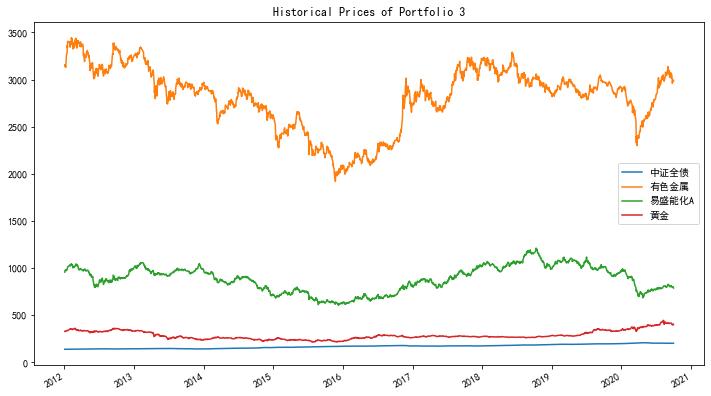

In [16]:
prices_p3.plot(figsize=(12,7),title = "Historical Prices of Portfolio 3")

In [17]:
rets_p3 = prices_p3.pct_change().dropna()
rets_p3.head(4)

,中证全债,有色金属,易盛能化A,黄金
2012-01-05,-0.000358,0.004758,0.016301,0.009917
2012-01-06,0.001649,-0.003222,0.004652,0.001807
2012-01-09,0.001217,-0.006266,0.004865,-0.004630
2012-01-10,0.000858,0.007232,-0.004842,0.003051


In [18]:
#计算资产组合的协方差矩阵
covmax_p3 = rets_p3.cov()
covmax_p3

,中证全债,有色金属,易盛能化A,黄金
中证全债,7.035589e-07,-6.776215e-07,-5.840146e-07,4.310277e-07
有色金属,-6.776215e-07,9.401564e-05,5.000104e-05,1.677908e-05
易盛能化A,-5.840146e-07,5.000104e-05,1.028536e-04,1.176820e-05
黄金,4.310277e-07,1.677908e-05,1.176820e-05,7.662959e-05


In [19]:
corr_p3 = rets_p3.corr()
corr_p3

,中证全债,有色金属,易盛能化A,黄金
中证全债,1.000000,-0.083318,-0.068654,0.058703
有色金属,-0.083318,1.000000,0.508475,0.197683
易盛能化A,-0.068654,0.508475,1.000000,0.132557
黄金,0.058703,0.197683,0.132557,1.000000


---

### <font color = 'midnightblue'> **4.设置优化组合的目标方程** </font>

为了研究在不同的目标下投资组合的绩效，我们主要设计了5个不同的目标方程：*最大化夏普比，最大回撤最小化，预期损失CVaR最小化，风险平价，等预期损失贡献，* 并根据结果来构建五个投资组合。

- 1. 最大化夏普比

***W.Sharp***最早在研究共同基金的表现时提出了*Reward-to-Variability ratio(R/V)* 即后来被称为的夏普比率。他认为投资组合的表现可以通过未来的预期收益 $E[r_p]$ 和组合风险 $\sigma_p$ 来衡量，并假设所有的投资者都可以以市场上的无风险利率 $r_f$ 进行自由借贷，则表现最优的投资组合应满足夏普比率最大。该比率的分子部分为超额收益，分母为组合的年化标准差，衡量每单位风险所能带来的超额收益。

<font color = 'blue'>
\begin{equation}
Sharp Ratio = \frac{E[r_p] - r_f}{\sigma_p}
\end{equation}
</font>

In [143]:
def annu_rets(r,T):
    """
    convert the non-annual returns to annualized returns
    r: non-annual returns series
    T: periods per year for the returns, i.e. T = 12 for onverting monthly data to annual
    """
    compounded_growth = (1+r).prod()
    t = r.shape[0] #number of periods, i.e. t=24 for 2-year monthly record
    return compounded_growth**(T/t)-1

def obj_sharpratio(w,rets=rets_p3, rf = 0.02,small_weights = 0.02):
    """
    objective function of sharp ratio
    w : weights of assets
    rets : dataframe return series of assets
    rf : constant risk free rate defaulted as 1%
    return an objective function to minimize the "negative sharp ratio"
    """
    #weighted portfolio returns
    port_rets = rets @ w
    #annulize portfolio returns 
    annu_r = annu_rets(port_rets,252)
    #excess returns of portfolio returns
    excess_rets = annu_r - rf

    #compute the covmatrix of the rets
    covmatrix = rets.cov()
    #volatility of portfolio
    annu_portvol = ((w @ covmatrix @ w)** 0.5) * np.sqrt(252)
    
    #Create a penalty term for small weights
    for i in range(len(rets.columns)):
        smp = 0
        if w[i] < small_weights:
            smp=(100 * np.sum(w[i])**0.5)
            
    #create a penalty component for sum of weights
    weight_pen = 100 * (1 - np.sum(w))**2
    
    sr = excess_rets/annu_portvol 
        
    return -sr + smp + weight_pen

- 2. 最大回撤最小化


最大回撤率是指统计周期内的最大产品净值的时点往后推，当产品净值回落到最低点时，产品收益率的回撤幅度。

<font color = 'blue'>
\begin{equation}
\min\limits_w  MaxDrawdown(\sum_{i=1}^N{w_i \cdot r_i})
\end{equation}
</font>
    
***s.t.*** $0 \leq w_i \leq 1$, $\sum_{i=1}^n {w_i = 1}$

上述公式中，$w_i$ 为组合中第 $i$ 个资产的权重，$r_i$ 为其收益率时间序列。为了找到组合中收益序列的最大回撤，需要首先计算累计收益时间序列和截至每个时刻的最大累计收益。每当累计收益跌至最大累计收益以下时，称为回撤，跌幅以最大累计收益的百分比来衡量。

In [142]:
def compute_drawdown(x):
    """
    calculate the drawdown for a given return series x 
    """
    cumulative_rets = (1+x).cumprod()
    max_cum_rets = cumulative_rets.cummax()
    drawdowns = - (cumulative_rets/max_cum_rets - 1)
    return drawdowns

def obj_maxdd(w,r=rets_p3,small_weights = 0.02):
    """
    returns an objective funstion to be optimized
    ------------------------------------------
    parameters:
    w is the weights of assets
    r is the returns series for all assets
    """
    # Compute the portfolio rets series
    port_rets = r @ w    
    
    #Max drawdown
    maxdd = compute_drawdown(port_rets).max()
    
    #create a penalty component for sum of weights
    weight_pen = 100 * (1 - np.sum(w))**2
    
    #create a pennalty component for small weights
    for i in range(len(r.columns)):
        smp = 0
        if w[i] < small_weights:
            smp=(100 * np.sum(w[i])**0.5)
        
    #objective function to minimize
    obj_fun = maxdd + weight_pen + smp
    return obj_fun

- 3. 最小化预期损失CVaR方程

为了构建一个能够达到降低极端损失目的的投资组合，我们选择了将CVaR作为优化目标方程。CVaR (*conditional value at risk*) 直译为条件风险价值，通常也称预期损失 (*Expected shortfall*) ，其含义为在投资组合的损失超过某个给定VaR值的条件下，该投资组合的平均损失值。与最常见的VaR相比，CVaR具有更好的特性，诸如具有次可加性、凸性以及齐次性等。在这里，我们采用***Rockafellar and Uryasev***提出的CVaR优化方法。

首先定义权重向量$w = (w_1,w_2,...,w_n)$ 其中 $w_j$ 表示投资组合中第j个资产,且满足 $w_j \geq 0$  对于 $j = 1,...,n$, $\sum_{j=1}^n w_j= 1$. 同时定义收益向量 $y = (y_1,...,y_n)$ 且收益的密度方程为 $p(y)$

则投资组合的收益可以通过求加权平均得到，组合的损失方程(*Loss Function*)即为收益方程的负数：
<font color = 'blue'>
\begin{equation}
L(w,y) = -[w_1 y_1 + ... + w_n y_n] = -w^T y
\end{equation} 
</font>



为了达到最小化CVaR的目标，***Uryasev***引入了一个辅助方程$F_{\alpha}(w,\gamma)$,并通过求解使得非凸优化问题转化为线性问题来得到全局解。

<font color = 'blue'>
\begin{equation}
F_{\alpha}(w,\gamma) = \gamma + \frac{1}{1-\alpha} \int_{L(w,y) \geq \gamma} [L(w,y) - \gamma]^+ p(y)dy
\end{equation} 
</font>

其中 $\gamma = VaR_{\alpha}(y)$



由于观测样本数有限，所以通过使用样本集$y_1,...,y_q$可将上述方程近似为：
<font color = 'blue'>
\begin{equation}
\tilde{F_{\alpha}}(w,\gamma) = \gamma + \frac{1}{q(1-\alpha)} \sum_{k=1}^q [-w^T y_k - \gamma]^+
\end{equation} 
</font>


即求解下面等价方程的最小值，可以看到该式为线性表达式
<font color = 'blue'>
\begin{equation}
\min \limits_{w}: CVaR_{\alpha}(w,\gamma) = \gamma + \frac{1}{q(1-\alpha)} \sum_{k=1}^q \mu_k
\end{equation}
</font>
***s.t.*** 

$w_j \geq 0$, $\sum_{j=1}^n w_j= 1$ 对于 $j = 1,...,n$

$\mu_k \geq 0$ 且 $x^Ty_k + \gamma + \mu_k \geq 0$ 对于$k = 1,2,...q$

In [141]:
def obj_cvar_minimization(w, rets=rets_p3, level = 5, small_weights = 0.02):
    """
    
    """
    alpha = level/100
    z = norm.ppf(alpha)
    covmatrix = rets.cov()
    annu_cov = covmatrix*252
    port_vol = ((w @ covmatrix @ w)**0.5) * np.sqrt(252)
    mu = (1+rets.mean())**252 - 1
    
    #compute the function
    cvar =  -(w @ mu) + port_vol * z / alpha

    #create a pennalty component for small weights
    for i in range(len(rets.columns)):
        smp = 0
        if w[i] < small_weights:
            smp=(100 * np.sum(w[i])**0.5)

    #create a penalty component for sum of weights
    weight_pen = 100 * (1 - np.sum(w))**2
    
    obj_fun = -cvar + weight_pen + smp
    
    return obj_fun

- 4. 风险均衡目标方程


风险均衡理论 (Risk Parity) 最早由钱恩平提出，由此理论产生的等风险贡献投资组合(ERC Portfolio) 使用投资组合收益的波动率作为风险指标，并以组合下每个资产对组合波动率贡献 (Risk Contribution RC) 相同为目标，从而确定投资组合中最佳的配置权重。

投资组合的风险可以写成偏微分的形式

<font color = 'blue'>
\begin{equation}
\sigma_p = \sqrt{W'\Sigma W} = \sum_{i=1}^{N} w_i \frac{\alpha \sigma_p}{\alpha w_i}
\end{equation}
</font>
                 
                 
<font color = 'blue'>
\begin{equation}
RC_i(w) = w_i \frac{\alpha \sigma{p}}{\alpha w_i} = \frac{(\Sigma W)_i w_i}{\sqrt{W'\Sigma W}}
\end{equation}
</font>


可以看出上式满足 $\sum_{i=1}^N RC_i(w) = \sigma_{p}$


<font color = 'blue'>
\begin{equation}
MRC_i(w) = \frac{1}{\sigma p} w_i \frac{\alpha \sigma{p}}{\alpha w_i} = \frac{(\Sigma W)_i w_i}{W'\Sigma W}
\end{equation}
</font>

满足 $\sum_{i=1}^N MRC_i(w) = 1$


已知需要满足风险均衡的条件为： $RC_i = \frac{\sigma_p}{N} $ 或 $MRC_i = \frac{1}{N}$

                                                                                                
则在风险均衡要求下，最优投资组合权重可由求解下述方程得到：

<font color = 'blue'>
\begin{equation}
\min \limits_{w} \sum_{i=1}^{N}(RC_i - \frac{\sigma_p}{N})^2
\end{equation}
</font>

即为：

<font color = 'blue'>
\begin{equation}
\min \limits_{w} \sum_{i=1}^{N}(\frac{(\sum W)_i w_i}{\sqrt{W'\sum W}} - \frac{\sigma_p}{N})^2
\end{equation}
</font>
                                                                   

In [140]:
def obj_RiskParity1(w,rets=rets_p3,small_weights = 0.02):
    """
    create the objectivee function of risk parity portfolio
    """
    #covariance matrix
    covmatrix = rets.cov()
    #portfolio risk sigmaP
    port_risk = ((w @ covmatrix @ w)**0.5) * np.sqrt(252)
    
    #annulized covmatrix
    cov_annu = covmatrix * 252
    
    CW = cov_annu @ w
    N = len(rets.columns)
    equal_risk = port_risk/N
    #create a function F to be minimized
    numerator = []
    for i in range(len(rets.columns)):
        numerator.append(CW[i]*w[i])
        F = np.sum((numerator/port_risk - equal_risk)**2)
    
    #create a pennalty component for small weights
        smp = 0
        if w[i] < small_weights:
            smp=(100 * np.sum(w[i])**0.5)
            
    #create a penalty component for sum of weights
    weight_pen = 100 * (1 - np.sum(w))**2
    
    obj_fun = F + weight_pen + smp
    
    return obj_fun 

- 5. CVaR预期损失均衡目标方程

除了使用投资组合的方差来构建等风险贡献组合*Equal Risk Contribution (ERC) Portfolio*, ***K.Boudt et al*** 提出了将投资组合中资产的CVaR贡献作为构建组合优化的目标方程。通过将CVaR考虑到组合优化的问题中，投资者可以更好的对资产的下行风险(Downside Risk)进行管理和优化。一般来说，某个资产在投资组合中贡献的CVaR比例越大，该组合的下行风险越集中于该资产。为了达到最大化收益和最小化下行风险的最佳平衡， ***Boudt*** 提出了两种可行策略，第一个是使得组合中CVaR贡献占比最大的资产权重最小，另一个是使得组合内资产的预期损失贡献百分比相等。为了与上文中构建的风险均衡组合进行比较，这里我们采用第二种策略来构建一个CVaR均衡的组合，并假设投资组合的收益服从标准正态分布。


CVaR贡献可以写做投资组合中头寸的权重乘以投资组合CVaR相对于该权重的偏导数:

<font color = 'blue'>
\begin{equation}
C_i CVaR_w (\alpha) = w_i \frac{\alpha CVaR_w (\alpha)}{\alpha w_i} 
\end{equation}
</font>


CVaR风险贡献百分比：

<font color = 'blue'>
\begin{equation}
\%C_i CVaR_w (\alpha) = \frac{C_i CVaR_w (\alpha)}{CVaR_w (\alpha)} 
\end{equation}
</font>



<font color = 'blue'>
\begin{equation}
\%C_i CVaR_w (\alpha) = \frac{w_i \cdot [-\mu_i + \frac{(\sum {W})_i \cdot \phi(Z_{\alpha})}{\sqrt{W' \sum W} \cdot {\alpha}}]} {-W' \mu + \sqrt{W'\sum W} \cdot \frac{\phi (Z_{\alpha})}{\alpha}}
\end{equation}
</font> 

***s.t.*** $0 \leq w_i \leq 1$, $\sum{w_i = 1}$


其中，$\mu$和$\sum$ 分别代表资产的平均收益向量和协方差矩阵，$Z_{\alpha}$为标准正态分布的$\alpha$分位数，$\phi$为标准正态分布的密度函数。


此时，通过设立约束条件使得投资组合内各个资产的CVaR风险贡献百分比相等,即：

<font color = 'blue'>
\begin{equation}
\%C_1 CVaR_w (\alpha) = \%C_2 CVaR_w (\alpha) =...= \%C_N CVaR_w (\alpha) = \frac{1}{N}
\end{equation}
</font>


可达到目标方程:

<font color = 'blue'>
\begin{equation}
\min \limits_{w} \sum_{i=1}^{N}(\%C_i CVaR_w (\alpha) - \frac{1}{N})^2
\end{equation}
</font>

In [139]:
def obj_cvar_budgeting(w, rets=rets_p3, level = 5, small_weights = 0.02):
    """
    
    """
    N = len(rets.columns)
    alpha = level/100
    z = norm.ppf(alpha)
    covmatrix = rets.cov()
    annu_cov = covmatrix*252
    port_vol = ((w @ covmatrix @ w)**0.5) * np.sqrt(252)
    
    mu = (1+rets.mean())**252 - 1
    equal_percentage = 1 / N
    CW = annu_cov @ w
    
    #compute the function
    cvar = -(w @ mu) - port_vol * z / alpha
    
    # compute the cvar budgeting
    numerator = []
    for i in range(len(rets.columns)):
        numerator.append(w[i]*(-mu[i] + (CW[i] * z) / (port_vol * alpha)))
    obj_ccvar = np.sum((numerator/cvar - equal_percentage)**2)

    #create a pennalty component for small weights
    for i in range(N):
        smp = 0
        if w[i] < small_weights:
            smp=(100 * np.sum(w[i])**0.5)
    
    #create a penalty component for sum of weights
    weight_pen = 100 * (1 - np.sum(w))**2
    
    obj_fun = obj_ccvar + weight_pen + smp
    return obj_fun

---

## <font color = 'midnightblue'> **使用DE算法对上述目标方程进行优化求解，并构建相应投资策略** </font>

<font color = 'red'> **首先对投资组合 1 进行配置：**

#### 1. 最大化夏普比组合：Max Sharp Ratio Portfolio

差分进化算法最优值 =  -0.47068691567931253
差分进化算法可行解 =  [0.004327143421966346, 0.001, 0.001, 0.6129599410086981, 0.25787551792236607, 0.026832721715374264, 0.05582441910868474, 0.001, 0.001, 0.001, 0.0372289596510657]


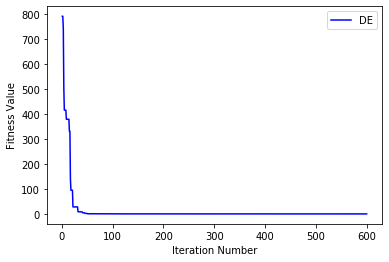

[0.004327143421966346,
 0.001,
 0.001,
 0.6129599410086981,
 0.25787551792236607,
 0.026832721715374264,
 0.05582441910868474,
 0.001,
 0.001,
 0.001,
 0.0372289596510657]

In [42]:
func = obj_sharpratio                         # Objective function
bounds = [(0.001,0.999),]*11                  # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_msr1 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_msr1

In [56]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_msr1 = de_msr1 / np.sum(de_msr1)
DEoptimal_weights_msr1

array([0.00432693, 0.00099995, 0.00099995, 0.61293009, 0.25786296,
       0.02683141, 0.0558217 , 0.00099995, 0.00099995, 0.00099995,
       0.03722715])

In [96]:
#计算整个投资组合的收益
DEport_msr1 = np.sum(DEoptimal_weights_msr1 * rets_p1,axis = 1)
pd.DataFrame(DEport_msr1,columns=['SR1']).head()

,SR1
2010-06-01,-0.016902
2010-06-02,0.009025
2010-06-03,-0.001278
2010-06-04,0.016828
2010-06-07,0.012193


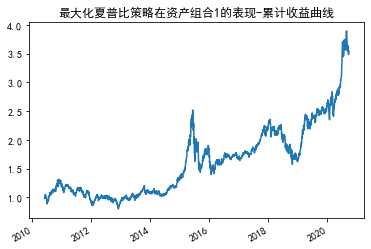

In [48]:
#显示最大化夏普比组合的累计收益曲线
cumrets_msr1 = (1+DEport_msr1).cumprod()
cumrets_msr1.plot(title = "最大化夏普比策略在资产组合1的表现-累计收益曲线")

In [49]:
#计算相关指标及统计量
de.Summary_Stats(pd.DataFrame(DEport_msr1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.133865,0.243363,-0.530574,6.080885,0.025973,0.03779,0.414396,-0.445959


#### 2. 最小化最大回撤组合：Min MaxDD Portfolio

差分进化算法最优值 =  0.40968598220687386
差分进化算法可行解 =  [0.001, 0.001, 0.001, 0.001, 0.001, 0.03918989289593362, 0.835000029307951, 0.001, 0.001, 0.017758367386167043, 0.09868349280627206]


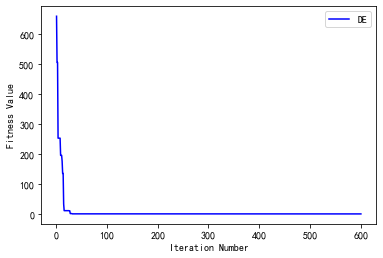

[0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.03918989289593362,
 0.835000029307951,
 0.001,
 0.001,
 0.017758367386167043,
 0.09868349280627206]

In [50]:
func = obj_maxdd                              # Objective function
bounds = [(0.001,0.999),]*11                  # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_MaxDD1 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_MaxDD1

In [58]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_mdd1 = de_MaxDD1 / np.sum(de_MaxDD1)
DEoptimal_weights_mdd1

array([0.00100237, 0.00100237, 0.00100237, 0.00100237, 0.00100237,
       0.03928292, 0.83698219, 0.00100237, 0.00100237, 0.01780052,
       0.09891775])

In [105]:
DEport_mdd1 = np.sum(DEoptimal_weights_mdd1 * rets_p1,axis = 1)
pd.DataFrame(DEport_mdd1,columns=['MaxDD 1']).head()

,MaxDD 1
2010-06-01,-0.011761
2010-06-02,0.000137
2010-06-03,-0.006547
2010-06-04,-0.000744
2010-06-07,-0.023418


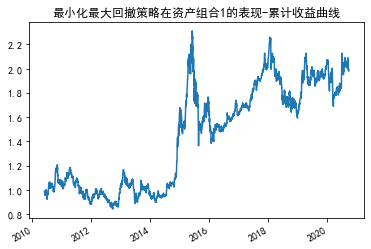

In [53]:
cumrets_mdd1 = (1+DEport_mdd1).cumprod()
cumrets_mdd1.plot(title = "最小化最大回撤策略在资产组合1的表现-累计收益曲线")

In [54]:
de.Summary_Stats(pd.DataFrame(DEport_mdd1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.070319,0.22187,-0.390129,8.014023,0.022802,0.033735,0.176438,-0.409913


#### 3. 风险平价组合：Risk Parity Portfolio

差分进化算法最优值 =  0.005138748723210954
差分进化算法可行解 =  [0.19108506209577306, 0.001, 0.001, 0.15581905824077955, 0.19724180990199586, 0.08467137619980031, 0.001, 0.001, 0.21889247945471713, 0.001, 0.1472709223201049]


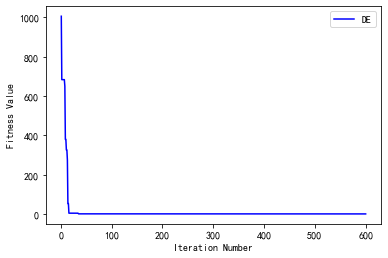

[0.19108506209577306,
 0.001,
 0.001,
 0.15581905824077955,
 0.19724180990199586,
 0.08467137619980031,
 0.001,
 0.001,
 0.21889247945471713,
 0.001,
 0.1472709223201049]

In [55]:
func = obj_RiskParity1                        # Objective function
bounds = [(0.001,0.999),]*11                  # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_rp1 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_rp1

In [60]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_rp1 = de_rp1 / np.sum(de_rp1)
DEoptimal_weights_rp1

array([0.19108875, 0.00100002, 0.00100002, 0.15582206, 0.19724562,
       0.08467301, 0.00100002, 0.00100002, 0.2188967 , 0.00100002,
       0.14727376])

In [61]:
DEport_rp1 = np.sum(DEoptimal_weights_rp1 * rets_p1,axis = 1)
pd.DataFrame(DEport_rp1,columns=['Risk Parity']).head()

,Risk Parity
2010-06-01,-0.018151
2010-06-02,0.011350
2010-06-03,-0.006243
2010-06-04,0.011424
2010-06-07,-0.002407


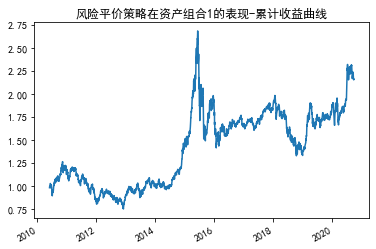

In [62]:
cumrets_rp1 = (1+DEport_rp1).cumprod()
cumrets_rp1.plot(title = "风险平价策略在资产组合1的表现-累计收益曲线")

In [63]:
de.Summary_Stats(pd.DataFrame(DEport_rp1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.07948,0.238637,-0.668844,6.93346,0.025944,0.038261,0.201317,-0.504994


#### 4. 最小化预期损失组合：Min CVaR Portfolio

差分进化算法最优值 =  7.204679346267872
差分进化算法可行解 =  [0.001, 0.07960885163800993, 0.001, 0.034884392444769596, 0.0011445068606719992, 0.001, 0.6708898327162671, 0.001, 0.02958045209438026, 0.09747312350184334, 0.048892369016567606]


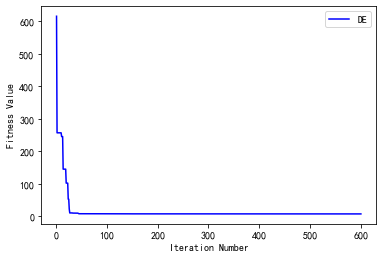

[0.001,
 0.07960885163800993,
 0.001,
 0.034884392444769596,
 0.0011445068606719992,
 0.001,
 0.6708898327162671,
 0.001,
 0.02958045209438026,
 0.09747312350184334,
 0.048892369016567606]

In [64]:
func = obj_cvar_minimization                  # Objective function
bounds = [(0.001,0.999),]*11                  # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_mincvar1 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_mincvar1

In [66]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_mincvar1 = de_mincvar1 / np.sum(de_mincvar1)
DEoptimal_weights_mincvar1

array([0.00103469, 0.08237044, 0.00103469, 0.03609451, 0.00118421,
       0.00103469, 0.69416266, 0.00103469, 0.03060658, 0.10085442,
       0.05058842])

In [116]:
DEport_mincvar1 = np.sum(DEoptimal_weights_mincvar1 * rets_p1,axis = 1)
pd.DataFrame(DEport_mincvar1,columns=['Min CVaR 1']).head()

,Min CVaR 1
2010-06-01,-0.011871
2010-06-02,0.001268
2010-06-03,-0.006666
2010-06-04,0.000092
2010-06-07,-0.020858


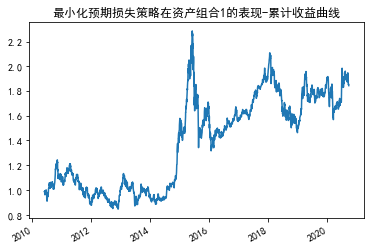

In [68]:
cumrets_mincvar1 = (1+DEport_mincvar1).cumprod()
cumrets_mincvar1.plot(title = "最小化预期损失策略在资产组合1的表现-累计收益曲线")

In [69]:
de.Summary_Stats(pd.DataFrame(DEport_mincvar1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.062692,0.219454,-0.515468,7.926174,0.02307,0.033952,0.144633,-0.424161


#### 5. 预期损失均衡组合：CVaR Budgeting Portfolio

差分进化算法最优值 =  0.45956084932748903
差分进化算法可行解 =  [0.001, 0.001, 0.11663005872216742, 0.09361397763221913, 0.001, 0.001, 0.34292335408747154, 0.14354936909171775, 0.05673699359076753, 0.12470302047500206, 0.1190739392558894]


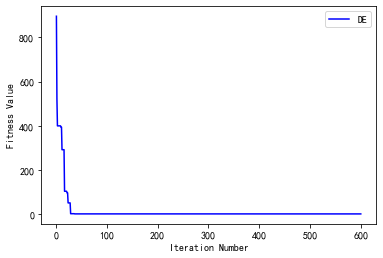

[0.001,
 0.001,
 0.11663005872216742,
 0.09361397763221913,
 0.001,
 0.001,
 0.34292335408747154,
 0.14354936909171775,
 0.05673699359076753,
 0.12470302047500206,
 0.1190739392558894]

In [70]:
func = obj_cvar_budgeting                     # Objective function
bounds = [(0.001,0.999),]*11                  # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_ccvar1 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_ccvar1

In [71]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_ccvar1 = de_ccvar1 / np.sum(de_ccvar1)
DEoptimal_weights_ccvar1

array([0.00099877, 0.00099877, 0.1164867 , 0.09349891, 0.00099877,
       0.00099877, 0.34250183, 0.14337292, 0.05666725, 0.12454974,
       0.11892757])

In [72]:
DEport_ccvar1 = np.sum(DEoptimal_weights_ccvar1 * rets_p1,axis = 1)
pd.DataFrame(DEport_ccvar1,columns=['CVaR Budgeting 1']).head()

,CVaR Budgeting
2010-06-01,-0.015253
2010-06-02,0.006878
2010-06-03,-0.007004
2010-06-04,0.004140
2010-06-07,-0.012785


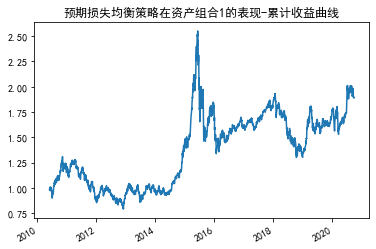

In [73]:
cumrets_ccvar1 = (1+DEport_ccvar1).cumprod()
cumrets_ccvar1.plot(title = "预期损失均衡策略在资产组合1的表现-累计收益曲线")

In [74]:
de.Summary_Stats(pd.DataFrame(DEport_ccvar1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.065487,0.228345,-0.695616,7.286038,0.024866,0.036537,0.150887,-0.489547


#### 6. 等权组合：Equal weighted Portfolio

In [134]:
weights_eq1 = [1/11]*11
eqport_rets1= np.sum(weights_eq1 * rets_p1,axis = 1)
eqport_rets1

2010-06-01   -0.015566
2010-06-02    0.009337
2010-06-03   -0.007258
2010-06-04    0.007372
2010-06-07   -0.008335
                ...   
2020-09-24   -0.021841
2020-09-25   -0.000783
2020-09-28   -0.002258
2020-09-29    0.004862
2020-09-30   -0.002271
Length: 2515, dtype: float64

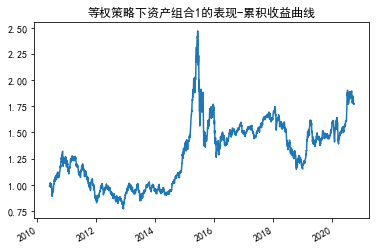

In [129]:
cumrets_eq1 = (1+eqport_rets1).cumprod()
cumrets_eq1.plot(title="等权策略下资产组合1的表现-累积收益曲线")

In [130]:
de.Summary_Stats(pd.DataFrame(eqport_rets1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.058559,0.237758,-0.686997,7.011464,0.025973,0.038228,0.116621,-0.534938


### **显示图例**

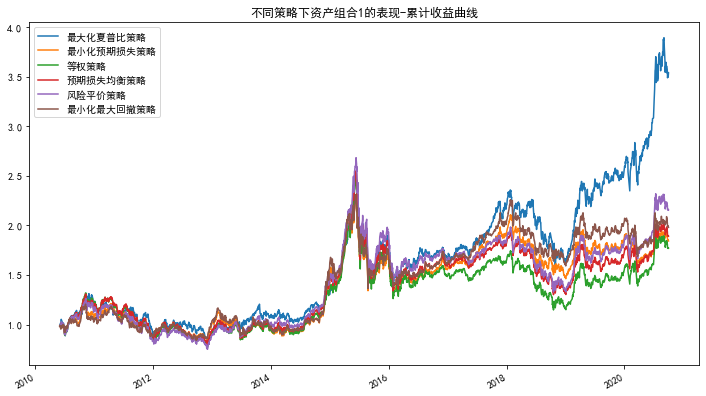

In [131]:
cumrets_msr1.plot(figsize = (12,7), label = "最大化夏普比策略",legend=True,title = "不同策略下资产组合1的表现-累计收益曲线")
cumrets_mincvar1.plot(label = "最小化预期损失策略",legend=True)
cumrets_eq1.plot(label="等权策略",legend=True)
cumrets_ccvar1.plot(label = "预期损失均衡策略",legend=True)
cumrets_rp1.plot(label = "风险平价策略",legend=True)
cumrets_mdd1.plot(label = "最小化最大回撤策略",legend=True)

In [87]:
btstats_de1 = pd.DataFrame({"最大化夏普比组合": DEport_msr1, "最小化最大回撤组合": DEport_mdd1, "风险平价组合": DEport_rp1, "最小化预期损失组合": DEport_mincvar1,"预期损失均衡组合":DEport_ccvar1 ,"等权重组合": eqport_rets})
de.Summary_Stats(btstats_de1)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
最大化夏普比组合,0.133865,0.243363,-0.530574,6.080885,0.025973,0.037790,0.414396,-0.445959
最小化最大回撤组合,0.070319,0.221870,-0.390129,8.014023,0.022802,0.033735,0.176438,-0.409913
风险平价组合,0.079480,0.238637,-0.668844,6.933460,0.025944,0.038261,0.201317,-0.504994
最小化预期损失组合,0.062692,0.219454,-0.515468,7.926174,0.023070,0.033952,0.144633,-0.424161
预期损失均衡组合,0.065487,0.228345,-0.695616,7.286038,0.024866,0.036537,0.150887,-0.489547
等权重组合,0.058559,0.237758,-0.686997,7.011464,0.025973,0.038228,0.116621,-0.534938


---

<font color = 'red'> **对资产组合 2 进行配置：**

#### 1. 最大化夏普比组合：Max Sharp Ratio Portfolio

差分进化算法最优值 =  -0.6589168249653745
差分进化算法可行解 =  [0.001, 0.001, 0.001, 0.001, 0.10646198170432458, 0.002460571550347762, 0.014089466500850144, 0.001, 0.001, 0.001, 0.14267982824826747, 0.582913270933747, 0.001, 0.001, 0.14284088866406644]


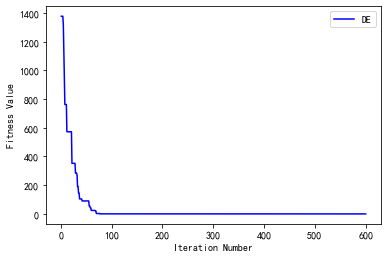

[0.001,
 0.001,
 0.001,
 0.001,
 0.10646198170432458,
 0.002460571550347762,
 0.014089466500850144,
 0.001,
 0.001,
 0.001,
 0.14267982824826747,
 0.582913270933747,
 0.001,
 0.001,
 0.14284088866406644]

In [93]:
func = obj_sharpratio                         # Objective function
bounds = [(0.001,0.999),]*15                  # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_msr2 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_msr2

In [94]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_msr2 = de_msr2 / np.sum(de_msr2)
DEoptimal_weights_msr2

array([0.00099955, 0.00099955, 0.00099955, 0.00099955, 0.10641452,
       0.00245947, 0.01408319, 0.00099955, 0.00099955, 0.00099955,
       0.14261622, 0.5826534 , 0.00099955, 0.00099955, 0.14277721])

In [97]:
#计算整个投资组合的收益
DEport_msr2 = np.sum(DEoptimal_weights_msr2 * rets_p2,axis = 1)
pd.DataFrame(DEport_msr2,columns=['SR2']).head()

,SR2
2012-01-05,-0.009398
2012-01-06,0.002486
2012-01-09,0.010458
2012-01-10,0.011163
2012-01-11,0.001821


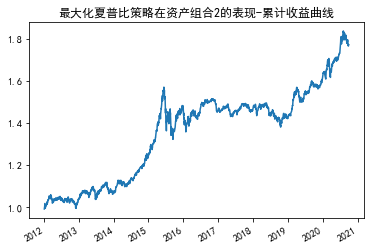

In [99]:
#显示最大化夏普比组合的累计收益曲线
cumrets_msr2 = (1+DEport_msr2).cumprod()
cumrets_msr2.plot(title = "最大化夏普比策略在资产组合2的表现-累计收益曲线")

In [100]:
#计算相关指标及统计量
de.Summary_Stats(pd.DataFrame(DEport_msr2))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.069659,0.075947,-0.500284,5.755747,0.008011,0.0119,0.507041,-0.158316


#### 2. 最小化最大回撤组合：Min MaxDD Portfolio

差分进化算法最优值 =  0.19314440394249746
差分进化算法可行解 =  [0.02014514222236497, 0.001, 0.001, 0.001, 0.001, 0.001, 0.08221971642960646, 0.046554203971515794, 0.001, 0.1818878676301087, 0.001, 0.25157677712605336, 0.001, 0.08725610009738283, 0.325888541880109]


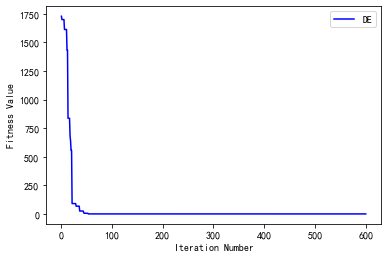

[0.02014514222236497,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.08221971642960646,
 0.046554203971515794,
 0.001,
 0.1818878676301087,
 0.001,
 0.25157677712605336,
 0.001,
 0.08725610009738283,
 0.325888541880109]

In [102]:
func = obj_maxdd                              # Objective function
bounds = [(0.001,0.999),]*15                  # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_MaxDD2 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_MaxDD2

In [103]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_mdd2 = de_MaxDD2 / np.sum(de_MaxDD2)
DEoptimal_weights_mdd2

array([0.02007431, 0.00099648, 0.00099648, 0.00099648, 0.00099648,
       0.00099648, 0.08193064, 0.04639052, 0.00099648, 0.18124836,
       0.00099648, 0.25069225, 0.00099648, 0.08694931, 0.32474274])

In [104]:
DEport_mdd2 = np.sum(DEoptimal_weights_mdd2 * rets_p2,axis = 1)
pd.DataFrame(DEport_mdd2,columns=['MaxDD 2 ']).head()

,MaxDD 2
2012-01-05,-0.003771
2012-01-06,0.002978
2012-01-09,0.011579
2012-01-10,0.012432
2012-01-11,0.002846


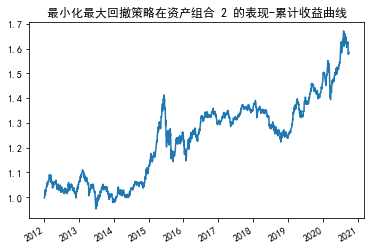

In [106]:
cumrets_mdd2 = (1+DEport_mdd2).cumprod()
cumrets_mdd2.plot(title = "最小化最大回撤策略在资产组合 2 的表现-累计收益曲线")

In [107]:
de.Summary_Stats(pd.DataFrame(DEport_mdd2))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.055638,0.096822,-0.30498,5.417329,0.010056,0.014565,0.257111,-0.191279


#### 3. 风险平价组合：Risk Parity Portfolio

差分进化算法最优值 =  0.0011472305780043993
差分进化算法可行解 =  [0.14346955897223507, 0.001, 0.001, 0.007715810944479982, 0.001, 0.001, 0.013321404516954013, 0.001, 0.001, 0.001, 0.0071717892762746625, 0.7795847597890786, 0.001, 0.001, 0.03918217894124328]


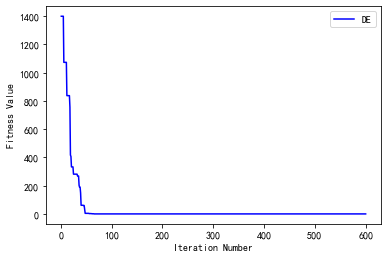

[0.14346955897223507,
 0.001,
 0.001,
 0.007715810944479982,
 0.001,
 0.001,
 0.013321404516954013,
 0.001,
 0.001,
 0.001,
 0.0071717892762746625,
 0.7795847597890786,
 0.001,
 0.001,
 0.03918217894124328]

In [108]:
func = obj_RiskParity1                        # Objective function
bounds = [(0.001,0.999),]*15                  # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_rp2 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_rp2

In [109]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_rp2 = de_rp2 / np.sum(de_rp2)
DEoptimal_weights_rp2

array([0.14354916, 0.00100055, 0.00100055, 0.00772009, 0.00100055,
       0.00100055, 0.0133288 , 0.00100055, 0.00100055, 0.00100055,
       0.00717577, 0.78001728, 0.00100055, 0.00100055, 0.03920392])

In [110]:
DEport_rp2 = np.sum(DEoptimal_weights_rp2 * rets_p2,axis = 1)
pd.DataFrame(DEport_rp2,columns=['Risk Parity 2']).head()

,Risk Parity 2
2012-01-05,0.000132
2012-01-06,0.002482
2012-01-09,0.005916
2012-01-10,0.005038
2012-01-11,-0.000272


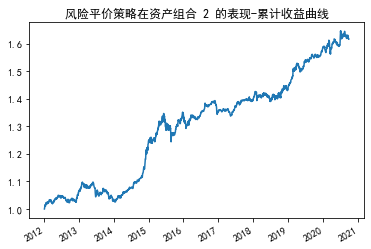

In [111]:
cumrets_rp2 = (1+DEport_rp2).cumprod()
cumrets_rp2.plot(title = "风险平价策略在资产组合 2 的表现-累计收益曲线")

In [112]:
de.Summary_Stats(pd.DataFrame(DEport_rp2))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.058178,0.044546,-0.135934,7.197012,0.004272,0.006333,0.614202,-0.076341


#### 4. 最小化预期损失组合：Min CVaR Portfolio

差分进化算法最优值 =  3.5844472986329743
差分进化算法可行解 =  [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.004997834986637608, 0.001, 0.001, 0.001, 0.26645608145398514, 0.12151115233694498, 0.19857962881223282, 0.1016748967350878, 0.2995820152987026]


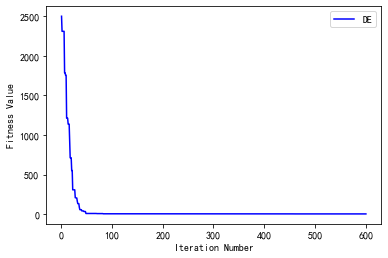

[0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.004997834986637608,
 0.001,
 0.001,
 0.001,
 0.26645608145398514,
 0.12151115233694498,
 0.19857962881223282,
 0.1016748967350878,
 0.2995820152987026]

In [118]:
func = obj_cvar_minimization                  # Objective function
bounds = [(0.001,0.999),]*15                  # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_mincvar2 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_mincvar2

In [119]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_mincvar2 = de_mincvar2 / np.sum(de_mincvar2)
DEoptimal_weights_mincvar2

array([0.0009982 , 0.0009982 , 0.0009982 , 0.0009982 , 0.0009982 ,
       0.0009982 , 0.00498885, 0.0009982 , 0.0009982 , 0.0009982 ,
       0.26597689, 0.12129263, 0.19822251, 0.10149205, 0.29904326])

In [120]:
DEport_mincvar2 = np.sum(DEoptimal_weights_mincvar2 * rets_p2,axis = 1)
pd.DataFrame(DEport_mincvar2,columns=['Min CVaR 2']).head()

,Min CVaR 2
2012-01-05,-0.003075
2012-01-06,0.002166
2012-01-09,0.009699
2012-01-10,0.013400
2012-01-11,0.006301


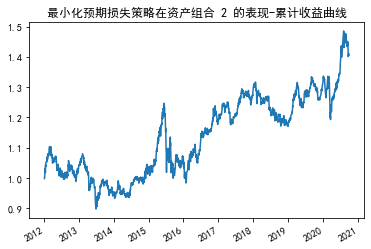

In [121]:
cumrets_mincvar2 = (1+DEport_mincvar2).cumprod()
cumrets_mincvar2.plot(title = "最小化预期损失策略在资产组合 2 的表现-累计收益曲线")

In [122]:
de.Summary_Stats(pd.DataFrame(DEport_mincvar2))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.04102,0.106858,-0.346294,5.619985,0.011223,0.016425,0.100131,-0.212131


#### 5. 预期损失均衡组合：CVaR Budgeting Portfolio

差分进化算法最优值 =  0.3998779237164801
差分进化算法可行解 =  [0.05380992406783217, 0.0843278573250823, 0.001, 0.16366354387541882, 0.20387743893265123, 0.010544816677533316, 0.047162350005971576, 0.001, 0.001, 0.026285261793691804, 0.13329490778444633, 0.001, 0.15123132044790855, 0.05885403301173575, 0.06583032360417854]


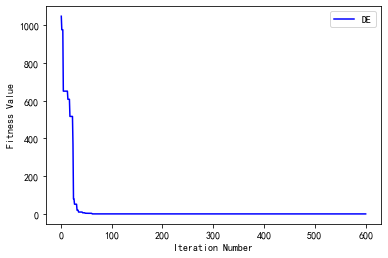

[0.05380992406783217,
 0.0843278573250823,
 0.001,
 0.16366354387541882,
 0.20387743893265123,
 0.010544816677533316,
 0.047162350005971576,
 0.001,
 0.001,
 0.026285261793691804,
 0.13329490778444633,
 0.001,
 0.15123132044790855,
 0.05885403301173575,
 0.06583032360417854]

In [123]:
func = obj_cvar_budgeting                     # Objective function
bounds = [(0.001,0.999),]*15                  # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_ccvar2 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_ccvar2

In [124]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_ccvar2 = de_ccvar2 / np.sum(de_ccvar2)
DEoptimal_weights_ccvar2

array([0.0536553 , 0.08408554, 0.00099713, 0.16319326, 0.2032916 ,
       0.01051452, 0.04702683, 0.00099713, 0.00099713, 0.02620973,
       0.13291189, 0.00099713, 0.15079676, 0.05868492, 0.06564116])

In [125]:
DEport_ccvar2 = np.sum(DEoptimal_weights_ccvar2 * rets_p2,axis = 1)
pd.DataFrame(DEport_ccvar2,columns=['CVaR Budgeting 2']).head()

,CVaR Budgeting 2
2012-01-05,-0.019927
2012-01-06,0.003716
2012-01-09,0.024371
2012-01-10,0.027898
2012-01-11,0.002644


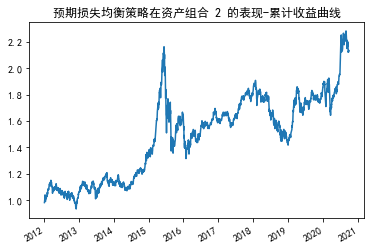

In [126]:
cumrets_ccvar2 = (1+DEport_ccvar2).cumprod()
cumrets_ccvar2.plot(title = "预期损失均衡策略在资产组合 2 的表现-累计收益曲线")

In [127]:
de.Summary_Stats(pd.DataFrame(DEport_ccvar2))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.093185,0.187986,-0.643747,6.738504,0.02031,0.03004,0.326353,-0.392513


#### 6. 等权组合：Equal weighted Portfolio

In [133]:
weights_eq2 = [1/15]*15
eqport_rets2= np.sum(weights_eq2 * rets_p2,axis = 1)
eqport_rets2

2012-01-05   -0.015187
2012-01-06    0.004373
2012-01-09    0.026919
2012-01-10    0.027781
2012-01-11   -0.000035
                ...   
2020-09-24   -0.018041
2020-09-25    0.000408
2020-09-28   -0.001784
2020-09-29    0.004760
2020-09-30   -0.002576
Length: 2126, dtype: float64

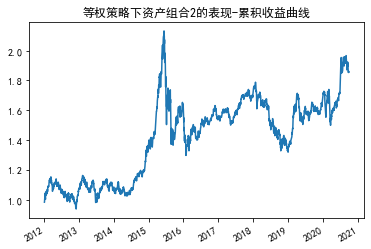

In [135]:
cumrets_eq2 = (1+eqport_rets2).cumprod()
cumrets_eq2.plot(title="等权策略下资产组合2的表现-累积收益曲线")

In [136]:
de.Summary_Stats(pd.DataFrame(eqport_rets2))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.075484,0.182022,-0.696941,7.279904,0.019755,0.029405,0.242623,-0.391084


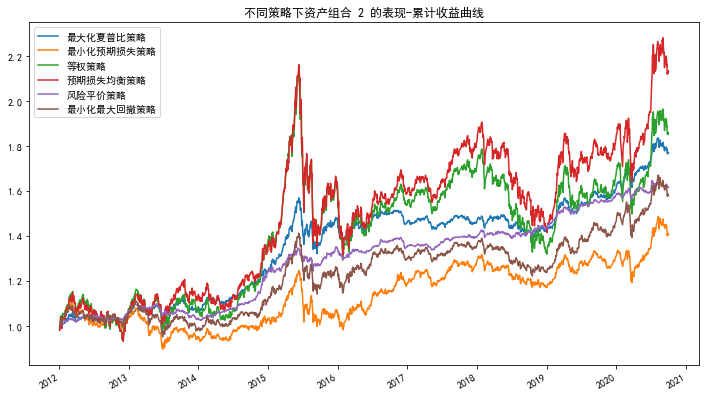

In [137]:
cumrets_msr2.plot(figsize = (12,7), label = "最大化夏普比策略",legend=True,title = "不同策略下资产组合 2 的表现-累计收益曲线")
cumrets_mincvar2.plot(label = "最小化预期损失策略",legend=True)
cumrets_eq2.plot(label="等权策略",legend=True)
cumrets_ccvar2.plot(label = "预期损失均衡策略",legend=True)
cumrets_rp2.plot(label = "风险平价策略",legend=True)
cumrets_mdd2.plot(label = "最小化最大回撤策略",legend=True)

In [138]:
btstats_de2 = pd.DataFrame({"最大化夏普比组合": DEport_msr2, "最小化最大回撤组合": DEport_mdd2, "风险平价组合": DEport_rp2, "最小化预期损失组合": DEport_mincvar2,"预期损失均衡组合":DEport_ccvar2,"等权重组合": eqport_rets2})
de.Summary_Stats(btstats_de2)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
最大化夏普比组合,0.069659,0.075947,-0.500284,5.755747,0.008011,0.011900,0.507041,-0.158316
最小化最大回撤组合,0.055638,0.096822,-0.304980,5.417329,0.010056,0.014565,0.257111,-0.191279
风险平价组合,0.058178,0.044546,-0.135934,7.197012,0.004272,0.006333,0.614202,-0.076341
最小化预期损失组合,0.041020,0.106858,-0.346294,5.619985,0.011223,0.016425,0.100131,-0.212131
预期损失均衡组合,0.093185,0.187986,-0.643747,6.738504,0.020310,0.030040,0.326353,-0.392513
等权重组合,0.075484,0.182022,-0.696941,7.279904,0.019755,0.029405,0.242623,-0.391084


---

<font color = 'red'> **对资产组合 3 进行配置：**

#### 1. 最大化夏普比组合：Max Sharp Ratio Portfolio

差分进化算法最优值 =  -1.8873453467390133
差分进化算法可行解 =  [0.9861338543405802, 0.001, 0.001, 0.02005610059214863]


C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


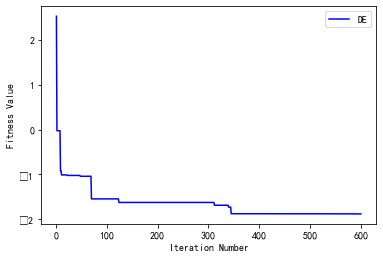

[0.9861338543405802, 0.001, 0.001, 0.02005610059214863]

In [144]:
func = obj_sharpratio                         # Objective function
bounds = [(0.001,0.999),]*4                  # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_msr3 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_msr3

In [145]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_msr3 = de_msr3 / np.sum(de_msr3)
DEoptimal_weights_msr3

array([0.97812307, 0.00099188, 0.00099188, 0.01989318])

In [146]:
#计算整个投资组合的收益
DEport_msr3 = np.sum(DEoptimal_weights_msr3 * rets_p3,axis = 1)
pd.DataFrame(DEport_msr3,columns=['SR 3']).head()

,SR 3
2012-01-05,-0.000132
2012-01-06,0.001650
2012-01-09,0.001097
2012-01-10,0.000902
2012-01-11,0.000643


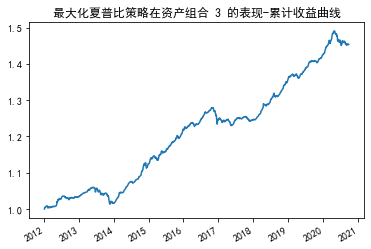

In [147]:
#显示最大化夏普比组合的累计收益曲线
cumrets_msr3 = (1+DEport_msr3).cumprod()
cumrets_msr3.plot(title = "最大化夏普比策略在资产组合 3 的表现-累计收益曲线")

In [148]:
#计算相关指标及统计量
de.Summary_Stats(pd.DataFrame(DEport_msr3))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.044961,0.013409,0.018836,13.600259,0.001032,0.001822,1.083367,-0.044076


#### 2. 最小化最大回撤组合：Min MaxDD Portfolio

差分进化算法最优值 =  0.03954152241960323
差分进化算法可行解 =  [0.9229860626303295, 0.001, 0.05467132820788922, 0.022455592315924033]


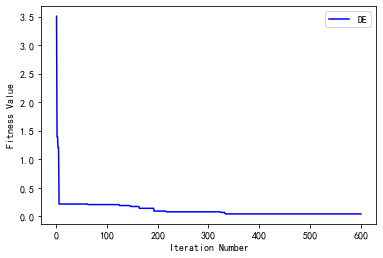

[0.9229860626303295, 0.001, 0.05467132820788922, 0.022455592315924033]

In [149]:
func = obj_maxdd                              # Objective function
bounds = [(0.001,0.999),]*4                   # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_MaxDD3 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_MaxDD3

In [150]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_mdd3 = de_MaxDD3 / np.sum(de_MaxDD3)
DEoptimal_weights_mdd3

array([0.92195994, 0.00099889, 0.05461055, 0.02243063])

In [151]:
DEport_mdd3 = np.sum(DEoptimal_weights_mdd3 * rets_p3,axis = 1)
pd.DataFrame(DEport_mdd3,columns=['MaxDD 3 ']).head()

,MaxDD 3
2012-01-05,0.000787
2012-01-06,0.001811
2012-01-09,0.001277
2012-01-10,0.000602
2012-01-11,0.000645


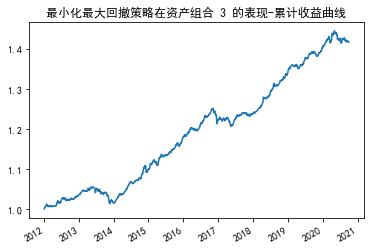

In [152]:
cumrets_mdd3 = (1+DEport_mdd3).cumprod()
cumrets_mdd3.plot(title = "最小化最大回撤策略在资产组合 3 的表现-累计收益曲线")

In [153]:
de.Summary_Stats(pd.DataFrame(DEport_mdd3))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.041867,0.015299,-0.140358,7.801152,0.001371,0.002043,0.753171,-0.039375


#### 3. 风险平价组合：Risk Parity Portfolio

差分进化算法最优值 =  0.00026561942388591956
差分进化算法可行解 =  [0.6633585885388503, 0.03561497656818144, 0.10915834504450858, 0.19220857705557032]


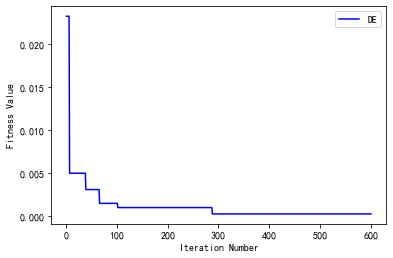

[0.6633585885388503,
 0.03561497656818144,
 0.10915834504450858,
 0.19220857705557032]

In [164]:
func = obj_RiskParity1                        # Objective function
bounds = [(0.001,0.999),]*4                   # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_rp3 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_rp3

In [165]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_rp3 = de_rp3 / np.sum(de_rp3)
DEoptimal_weights_rp3

array([0.6631328 , 0.03560285, 0.10912119, 0.19214315])

In [166]:
DEport_rp3 = np.sum(DEoptimal_weights_rp3 * rets_p3,axis = 1)
pd.DataFrame(DEport_rp3,columns=['Risk Parity 3']).head()

,Risk Parity 3
2012-01-05,0.003616
2012-01-06,0.001833
2012-01-09,0.000225
2012-01-10,0.000884
2012-01-11,0.002883


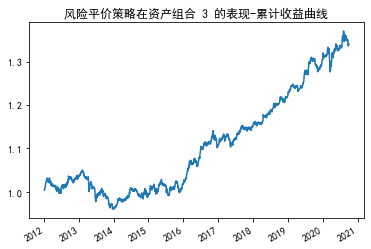

In [167]:
cumrets_rp3 = (1+DEport_rp3).cumprod()
cumrets_rp3.plot(title = "风险平价策略在资产组合 3 的表现-累计收益曲线")

In [168]:
de.Summary_Stats(pd.DataFrame(DEport_rp3))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.034972,0.037374,-0.137092,6.799562,0.003657,0.005092,0.129184,-0.085419


#### 4. 最小化预期损失组合：Min CVaR Portfolio

差分进化算法最优值 =  0.48487709323919287
差分进化算法可行解 =  [0.9613123876790114, 0.004278118227747473, 0.010669543960170742, 0.02028153178208908]


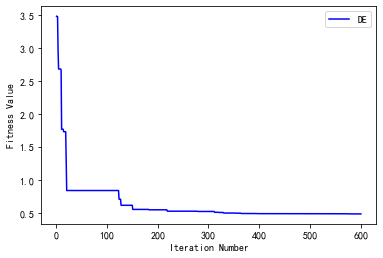

[0.9613123876790114,
 0.004278118227747473,
 0.010669543960170742,
 0.02028153178208908]

In [169]:
func = obj_cvar_minimization                  # Objective function
bounds = [(0.001,0.999),]*4                   # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_mincvar3 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_mincvar3

In [170]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_mincvar3 = de_mincvar3 / np.sum(de_mincvar3)
DEoptimal_weights_mincvar3

array([0.96464855, 0.00429297, 0.01070657, 0.02035192])

In [171]:
DEport_mincvar3 = np.sum(DEoptimal_weights_mincvar3 * rets_p3,axis = 1)
pd.DataFrame(DEport_mincvar3,columns=['Min CVaR 3']).head()

,Min CVaR 3
2012-01-05,0.000051
2012-01-06,0.001663
2012-01-09,0.001105
2012-01-10,0.000869
2012-01-11,0.000697


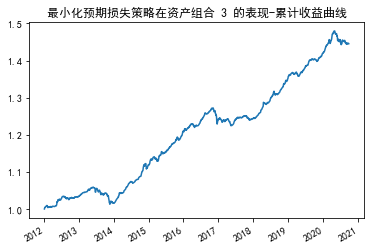

In [172]:
cumrets_mincvar3 = (1+DEport_mincvar3).cumprod()
cumrets_mincvar3.plot(title = "最小化预期损失策略在资产组合 3 的表现-累计收益曲线")

In [173]:
de.Summary_Stats(pd.DataFrame(DEport_mincvar3))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.044272,0.01334,-0.083332,12.698566,0.001069,0.001828,1.038818,-0.043214


#### 5. 预期损失均衡组合：CVaR Budgeting Portfolio

差分进化算法最优值 =  1.098029616380195
差分进化算法可行解 =  [0.1771308433194603, 0.24962542227311013, 0.24280308423320768, 0.3330881916663471]


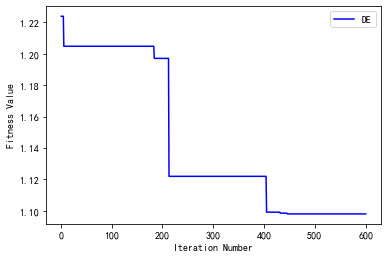

[0.1771308433194603,
 0.24962542227311013,
 0.24280308423320768,
 0.3330881916663471]

In [182]:
func = obj_cvar_budgeting                     # Objective function
bounds = [(0.001,0.999),]*4                   # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 20                                  # Population size, must be >= 4
mutate = 0.5                                  # Mutation factor [0,2]
recombination = 0.5                           # Recombination rate [0,1]
maxiter = 600                                 # Max number of generations (maxiter)

de_ccvar3 = de.main(func,bounds,popsize,mutate,recombination,maxiter)
de_ccvar3

In [183]:
#根据最优算法所得计算最优权重使得权重加总为1
DEoptimal_weights_ccvar3 = de_ccvar3 / np.sum(de_ccvar3)
DEoptimal_weights_ccvar3

array([0.17666312, 0.24896627, 0.24216195, 0.33220866])

In [184]:
DEport_ccvar3 = np.sum(DEoptimal_weights_ccvar3 * rets_p3,axis = 1)
pd.DataFrame(DEport_ccvar3,columns=['CVaR Budgeting 3']).head()

,CVaR Budgeting 3
2012-01-05,0.008363
2012-01-06,0.001216
2012-01-09,-0.001705
2012-01-10,0.001793
2012-01-11,0.007741


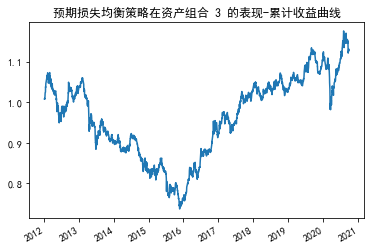

In [185]:
cumrets_ccvar3 = (1+DEport_ccvar3).cumprod()
cumrets_ccvar3.plot(title = "预期损失均衡策略在资产组合 3 的表现-累计收益曲线")

In [186]:
de.Summary_Stats(pd.DataFrame(DEport_ccvar3))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.014374,0.088002,-0.125425,5.957847,0.008945,0.012581,-0.172422,-0.315286


#### 6. 等权组合：Equal weighted Portfolio

In [187]:
weights_eq3 = [1/4]*4
eqport_rets3= np.sum(weights_eq3 * rets_p3,axis = 1)
eqport_rets3

2012-01-05    0.007655
2012-01-06    0.001221
2012-01-09   -0.001204
2012-01-10    0.001575
2012-01-11    0.006936
                ...   
2020-09-24   -0.007590
2020-09-25    0.003684
2020-09-28   -0.000482
2020-09-29    0.004479
2020-09-30   -0.003414
Length: 2126, dtype: float64

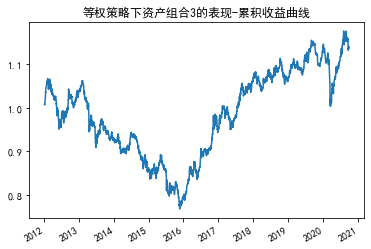

In [189]:
cumrets_eq3 = (1+eqport_rets3).cumprod()
cumrets_eq3.plot(title="等权策略下资产组合3的表现-累积收益曲线")

In [190]:
de.Summary_Stats(pd.DataFrame(eqport_rets3))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.01529,0.081933,-0.108366,5.577941,0.008336,0.01177,-0.174331,-0.281269


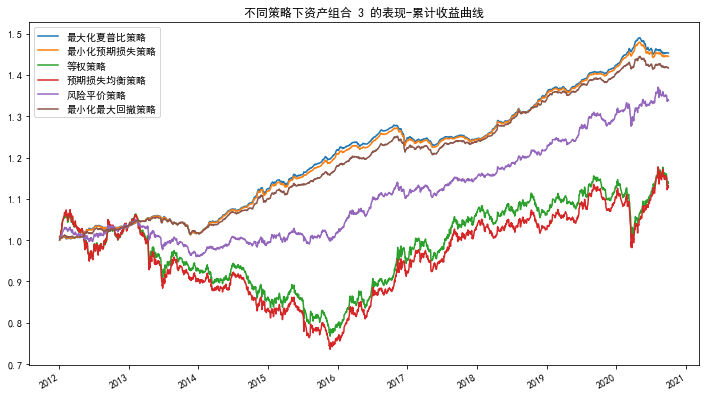

In [192]:
cumrets_msr3.plot(figsize = (12,7), label = "最大化夏普比策略",legend=True,title = "不同策略下资产组合 3 的表现-累计收益曲线")
cumrets_mincvar3.plot(label = "最小化预期损失策略",legend=True)
cumrets_eq3.plot(label="等权策略",legend=True)
cumrets_ccvar3.plot(label = "预期损失均衡策略",legend=True)
cumrets_rp3.plot(label = "风险平价策略",legend=True)
cumrets_mdd3.plot(label = "最小化最大回撤策略",legend=True)

In [191]:
btstats_de3 = pd.DataFrame({"最大化夏普比组合": DEport_msr3, "最小化最大回撤组合": DEport_mdd3, "风险平价组合": DEport_rp3, "最小化预期损失组合": DEport_mincvar3,"预期损失均衡组合":DEport_ccvar3,"等权重组合": eqport_rets3})
de.Summary_Stats(btstats_de3)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
最大化夏普比组合,0.044961,0.013409,0.018836,13.600259,0.001032,0.001822,1.083367,-0.044076
最小化最大回撤组合,0.041867,0.015299,-0.140358,7.801152,0.001371,0.002043,0.753171,-0.039375
风险平价组合,0.034972,0.037374,-0.137092,6.799562,0.003657,0.005092,0.129184,-0.085419
最小化预期损失组合,0.044272,0.013340,-0.083332,12.698566,0.001069,0.001828,1.038818,-0.043214
预期损失均衡组合,0.014374,0.088002,-0.125425,5.957847,0.008945,0.012581,-0.172422,-0.315286
等权重组合,0.015290,0.081933,-0.108366,5.577941,0.008336,0.011770,-0.174331,-0.281269
